<a href="https://colab.research.google.com/github/syma-afsha/Machine_Learning/blob/main/Syma_Afsha_Lab_01_Gradient_Descent_for_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Gradient Descent for Linear Regression


## Remainder
Before starting, read the document [General information about the labs.pdf](https://moodle2.udg.edu/pluginfile.php/1763258/mod_resource/content/8/ML_Labs_info.pdf)

Among other useful information, it tells you to make a copy of this Colab notebook BEFORE you try to run it:

- Make a copy on your own Colab space by clicking on the `copy to drive` button.
- Alternatively you could go to the menu `File > Save a copy in Drive`
- Then, open your new file on a new tap and rename it, and you’re ready to start tinkering with the code
- Look carefully at the existing code before you execute it. Try to understand what the code is doing. Part of your learning outcome is to understand it, and we will quiz you about it.
- In several places of the code, you’ll find `#__________TO DO_________`.
There you should introduce your code.

Once you are done, submit this notebook by the lab deadline, with the cells executed and including your **answers** in the text fields in $\color{red}{\text{red}}$ color.

Use `$\color{red}{\text{This is my red text}}$` to write "$\color{red}{\text{This is my red text}}$".

## Goals of this first lab
In this lab, you will:
- understand the process of optimizing the parameters $\theta_0$ and $\theta_1$ using gradient descent.
- visualize what the gradient looks like at a given point of the cost function
- complete a gradient descent routine
- analyse the impact of sizing the learning rate

<a name="toc_40291_2"></a>
# Problem Statement

In this assignment, you will use Python to compute the regression of a dataset (“rentData”), where we have the rent price of different apartments in Barcelona, according to their size. You will observe that we have two columns in this dataset: "$m^2$" and “price”, where “$m^2$” is an independent variable, corresponding to the size of the apartment in square meters, and “price” is the dependent variable.

The first lines of the dataset we will use is shown below:

| Size ($m^2$)     | Price (euro) |
| ----------------| ------------------------ |
| 23               | 366                      |
| 18               | 578                      |
| 28               | 545                      |
| 30               | 429                      |
| 20               | 597                      |
| 15               | 256                      |


# Loading the required files
You can load into the temporal workspace of Colab the following required files:

*   the data file `rent-data.csv`, including the complete dataset of rental prices in euro, as a function of the size of the apartment in square meters.
*   file `aux_utils.py` with some routines that will be used in the lab

You should copy these files from your computer using the function `files.upload()`. Use the `Choose Files` button to upload both files from your local drive.

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving aux_utils.py to aux_utils (1).py
Saving rent-data.csv to rent-data (1).csv


## Additional tools
In this lab, we will also make use of:
- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data
- Routines in the aux_utils.py file, which should already be in the local directory

In [ ]:
import math, copy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from aux_utils import plt_house_x, plt_contour_wgrad, plt_gradients, plt_cost_vs_theta1
from google.colab import files
# import time
from IPython import display
from time import sleep


<ipython-input-33-08aaa319d7a2>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Next, we will load the dataset of `rent-data.csv` into a variable named `dataset`
Load the source data in the variables `xTrain` and `yTrain`

In [ ]:
dataset = genfromtxt('rent-data.csv', delimiter=';', skip_header = 1)
print(np.shape(dataset))
X_train = dataset[:,0]
Y_train = dataset[:,1]



(294, 2)


Now plot the data using `Matplotlib`

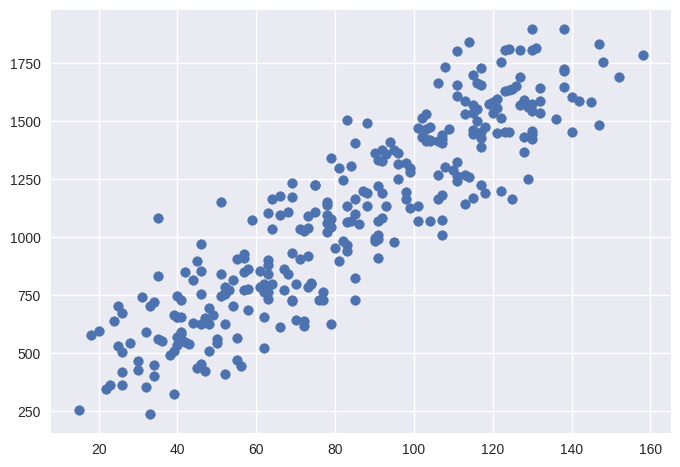

In [ ]:
plt.scatter(X_train, Y_train)
plt.show()

## Computing the Cost
The **cost function**, also known as **objective function**, is a measure how well our model is predicting the target variable *y* (in this assignment, the *rental price* of an apartment). To predict *y*, we will use the feature variable *x* (*size* of the apartment in squared meters).

The equation to compute the cost is:
  $$J(\theta_0,\theta_1) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (h_{\theta}(x^{(i)}) - y^{(i)})^2 \tag{1}$$

where
  $$h_{\theta}(x^{(i)}) = \theta_1x^{(i)} + \theta_0 \tag{2}$$
  
- $h_{\theta}(x^{(i)})$ is our prediction for example $i$ using parameters $\theta_1,\theta_0$.  
- $(h_{\theta}(x^{(i)}) -y^{(i)})^2$ is the squared difference between the target value and the prediction.   
- These differences are summed over all the $m$ examples and divided by $2m$ to produce the cost, $J(\theta)$.  
>Note that in the lecture, summation ranges are typically from 1 to *m*, while code will be from 0 to *m*-1.

In [ ]:
#Function to calculate the cost
def compute_cost(x, y, theta1, theta0):

    m = x.shape[0]
    cost = 0

    for i in range(m):
        h_theta = theta1 * x[i] + theta0
        cost = cost + (h_theta - y[i])**2
    total_cost = 1 / (2 * m) * cost

    return total_cost

<a name="toc_40291_2.1"></a>
## Gradient descent summary
So far in this course, you have developed a linear model that predicts $h_{\theta}(x^{(i)})$:

$$h_{\theta}(x^{(i)}) = \theta_1x^{(i)} + \theta_0 \tag{3}$$

In linear regression, you require input training data to fit the parameters $\theta_1$, $\theta_0$ by minimizing a measure of the error between our predictions $h_{\theta}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost$, $J(\theta)$. In training you measure the cost over all of our training samples $x^{(i)},y^{(i)}$
$$J(\theta) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (h_{\theta}(x^{(i)}) - y^{(i)})^2\tag{2}$$

\
In the lecture, *gradient descent* is described as:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \newline
\lbrace \newline
\theta_1 &:=  \theta_1 -  \alpha \frac{\partial J(\theta)}{\partial \theta_1} \tag{3}  \; \newline
 \theta_0 &:= \theta_0  -  \alpha \frac{\partial J(\theta)}{\partial \theta_0}  \newline \rbrace
\end{align*}$$
where, parameters $\theta_1$, $\theta_0$ are updated simultaneously. This means that we should calculate the partial derivatives for all the parameters before updating any of the parameters.

You can also see that $\alpha$, the *learning rate*, is a factor that multiplies the gradient. At every iteration, we want to go downhill to get to the minimum of $J(\theta)$. Therefore, given a value of $(\theta_1,\theta_0)$, we will take a small step in the direction of maximum descent. How big this step is, will depend on the value of the learning rate $\alpha$. If $\alpha$ is too small, gradient descent will be very slow. On the contrary, if the learning rate is too big, gradient descent can overshoot the minimum and it may fail to converge, or even diverge.

The gradient is defined as:
$$
\begin{align}
\frac{\partial J(\theta)}{\partial \theta_1}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(\theta)}{\partial \theta_0}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (h_{\theta}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$



<a name="toc_40291_2.2"></a>
## Implement Gradient Descent
You will implement gradient descent algorithm for one feature. You will need three functions.
- `compute_gradient` implementing equation (4) and (5) above
- `compute_cost` implementing equation (2) above (code from previous lab)
- `gradient_descent`, utilizing compute_gradient and compute_cost

Conventions:
- The naming of python variables containing partial derivatives follows this pattern,$\frac{\partial J(\theta)}{\partial \theta_0}$  will be `dj_dtheta0`.



<a name="toc_40291_2.3"></a>
### compute_gradient
<a name='ex-01'></a>
The function `compute_gradient`  implements eqs. (4) and (5) above. It returns the partial derivatives $\frac{\partial J(\theta)}{\partial \theta_1}$,$\frac{\partial J(\theta)}{\partial \theta_0}$.

In [ ]:
def compute_gradient(x, y, theta1, theta0):
    """
    Computes the partial derivatives for linear regression
    Args:
      x (ndarray (m,))        : Data, m examples
      y (ndarray (m,))        : target values
      theta1, theta0 (scalar) : model parameters
    Returns
      dj_dtheta1 (scalar)     : The gradient of the cost w.r.t. the parameter theta1
      dj_dtheta0 (scalar)     : The gradient of the cost w.r.t. the parameter theta0
     """

    # Number of training examples
    m = x.shape[0]
    dj_dtheta1 = 0
    dj_dtheta0 = 0

    for i in range(m):
        h_theta = theta1 * x[i] + theta0
        dj_dtheta1_i = (h_theta - y[i]) * x[i]
        dj_dtheta0_i = h_theta - y[i]
        dj_dtheta0 += dj_dtheta0_i
        dj_dtheta1 += dj_dtheta1_i
    dj_dtheta1 = dj_dtheta1 / m
    dj_dtheta0 = dj_dtheta0 / m

    return dj_dtheta1, dj_dtheta0

<br/>

In the lecture you saw how gradient descent utilizes the partial derivative of the cost with respect to a parameter at a point to update that parameter.   
Let's use our `compute_gradient` function to find and plot some partial derivatives of our cost function relative to one of the parameters, $\theta_1$. Our function `plt_gradients` will plot the derivative of $J$ at the points corresponding to $\theta_1 = -200$, $\theta_1 =45$ and $\theta_1 =300$.


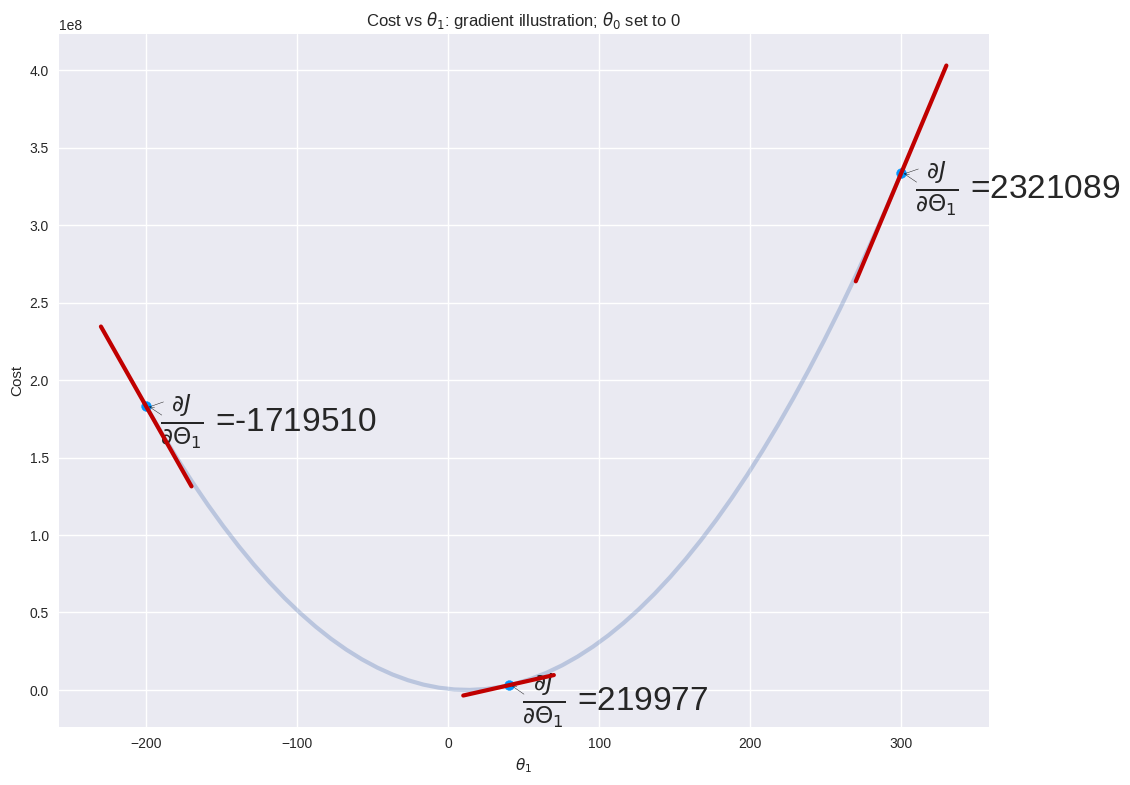

In [ ]:
plt_gradients(X_train, Y_train, compute_cost, compute_gradient)
plt.show()

Above, the left plot shows $\frac{\partial J(\theta)}{\partial \theta_1}$ or the slope of the cost curve relative to $\theta_1$ at three points. On the right side of the plot, the derivative is positive, while on the left it is negative. Due to the 'bowl shape', the derivatives will always lead gradient descent toward the bottom where the gradient is zero. You can also observe that the magnitude of the derivative is smaller as you approach the minimum of the cost function.

Here we are optimizing a function $J$ that depends on $\theta_1$ and $\theta_0$. To show this plot, we have fixed $\theta_0=0$. Note that gradient descent will utilize both $\frac{\partial J(\theta)}{\partial \theta_1}$ and $\frac{\partial J(\theta)}{\partial \theta_0}$ to update parameters.

Finally, it should also be noted that **the gradient points *away* from the minimum**. Review equation (3) above. The scaled gradient is *subtracted* from the current value of $\theta_1$ or $\theta_0$. This moves the parameter $\theta$ in a direction that will reduce the cost.



<a name="toc_40291_2.5"></a>
###  Gradient Descent
Now that gradients can be computed,  gradient descent, described in equation (3) above, can be implemented below in the function `gradient_descent`.


Your task is to complete the missing code. Below, you will utilize this function to find optimal values of $\theta_1$ and $\theta_0$ on the training data.

In [ ]:
def gradient_descent(x, y, theta1_in, theta0_in, alpha, num_iters, cost_function, gradient_function, visualize):
    """
    Performs gradient descent to fit w,b. Updates w,theta0 by taking
    num_iters gradient steps with learning rate alpha

    Args:
      x (ndarray (m,))            : Data, m examples
      y (ndarray (m,))            : target values
      theta1_in,theta0_in (scalar): initial values of model parameters
      alpha (float)               : Learning rate
      num_iters (int)             : number of iterations to run gradient descent
      cost_function               : function to call to produce cost
      gradient_function           : function to call to produce gradient

    Returns:
      theta1 (scalar): Updated value of parameter after running gradient descent
      theta0 (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [theta1,theta0]
      """

    theta1 = copy.deepcopy(theta1_in) # avoid modifying global theta1_in
    # An array to store cost J and theta values at each iteration primarily for graphing later
    J_history = []
    p_history = []
    theta0 = theta0_in
    theta1 = theta1_in

    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dtheta1, dj_dtheta0 = gradient_function(x, y, theta1 , theta0)

        # Update Parameters using equation (3) above
        theta0 = theta0 - alpha * dj_dtheta0
        theta1 = theta1 - alpha * dj_dtheta1

        if visualize==1:
            # plot the images
            plt.scatter(x, y)
            plt.plot(x, theta1*x+theta0, color='r')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.close()
            #sleep(0.5)

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( cost_function(x, y, theta1 , theta0))
            p_history.append([theta1 , theta0])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e}",
                  f"dj_dtheta1: {dj_dtheta1: 0.3e}, dj_dtheta0: {dj_dtheta0: 0.3e}",
                  f"theta1: {theta1: 0.3e}, theta0:{theta0: 0.5e}")
            if visualize==2:
                plt.scatter(x, y)
                plt.plot(x, theta1 * x + theta0, color='r')
                plt.show(); plt.close()

    return theta1, theta0, J_history, p_history #return theta1 and J,w history for graphing

Initialise $\theta_1$ and $\theta_0$ to 0. Start running 100 iterations of the gradient descent algorithm. And set the learning rate $\alpha$ to 1.0e-5. Finally, call the  function `gradient_descent` using all the parameters you just defined, and this should provide you with the optimal values for $\theta_1$ and $\theta_0$ using your training data.

```
# increase iterations
iterations = 100000
```


In [ ]:
# initialize parameters
theta1_init = 0 #_____________TO DO_____________
theta0_init = 0 #_____________TO DO_____________

# some gradient descent settings
iterations =100 #_____________TO DO_____________
alpha =   1e-5   #_____________TO DO_____________
vis = 0
# run gradient descent
theta_1_final, theta_0_final, J_hist, p_hist = gradient_descent( X_train,Y_train, theta1_init, theta0_init, alpha,
                                                    iterations, compute_cost, compute_gradient, vis)
print(f"(theta1, theta0) found by gradient descent: ({theta_1_final:5.4f},{theta_0_final:5.4f})")

Iteration    0: Cost 5.75e+05 dj_dtheta1: -1.033e+05, dj_dtheta0: -1.092e+03 theta1:  1.033e+00, theta0: 1.09224e-02
Iteration   10: Cost 1.21e+05 dj_dtheta1: -4.446e+04, dj_dtheta0: -4.850e+02 theta1:  7.721e+00, theta0: 8.25768e-02
Iteration   20: Cost 3.71e+04 dj_dtheta1: -1.914e+04, dj_dtheta0: -2.236e+02 theta1:  1.060e+01, theta0: 1.14904e-01
Iteration   30: Cost 2.15e+04 dj_dtheta1: -8.241e+03, dj_dtheta0: -1.110e+02 theta1:  1.184e+01, theta0: 1.30299e-01
Iteration   40: Cost 1.86e+04 dj_dtheta1: -3.548e+03, dj_dtheta0: -6.258e+01 theta1:  1.237e+01, theta0: 1.38404e-01
Iteration   50: Cost 1.80e+04 dj_dtheta1: -1.527e+03, dj_dtheta0: -4.172e+01 theta1:  1.260e+01, theta0: 1.43371e-01
Iteration   60: Cost 1.79e+04 dj_dtheta1: -6.574e+02, dj_dtheta0: -3.273e+01 theta1:  1.270e+01, theta0: 1.46987e-01
Iteration   70: Cost 1.79e+04 dj_dtheta1: -2.829e+02, dj_dtheta0: -2.887e+01 theta1:  1.275e+01, theta0: 1.50021e-01
Iteration   80: Cost 1.79e+04 dj_dtheta1: -1.216e+02, dj_dtheta0


Take a moment and note some characteristics of the gradient descent process printed above.  

- The cost starts large and rapidly declines as described in the slide from the lecture.
- The partial derivatives, `dj_dtheta1`, and `dj_dtheta0` also get smaller, rapidly at first and then more slowly. As shown in the slides from the lecture, as the process nears the 'bottom of the bowl' progress is slower due to the smaller value of the derivative at that point.
- progress slows even while the learning rate, $\alpha$, remains fixed

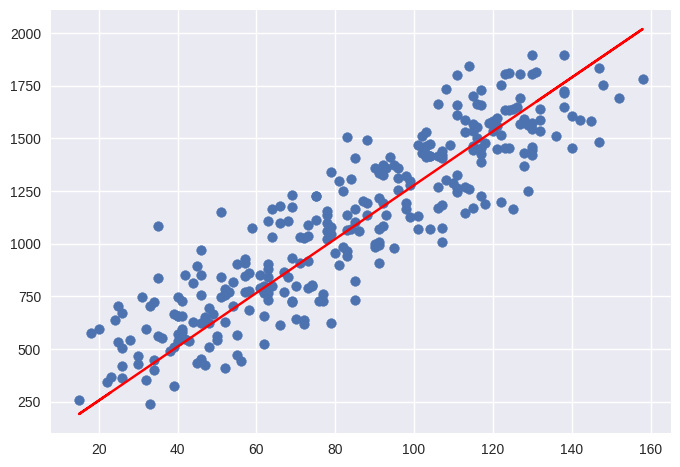

In [ ]:
#add points to plot
plt.scatter(X_train, Y_train)

#add line of best fit to plot
plt.plot(X_train, theta_1_final*X_train+theta_0_final, color='r')

### Cost versus iterations of gradient descent
A plot of cost versus iterations is a useful measure of progress in gradient descent. Cost should always decrease in successful runs. The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.

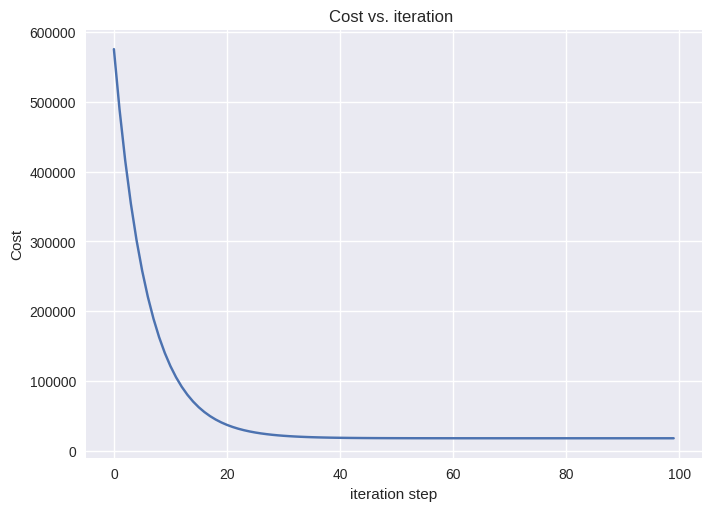

100

In [ ]:
# plot cost versus iteration
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(7,5))
ax.plot(J_hist)
ax.set_title("Cost vs. iteration ")
ax.set_ylabel('Cost')
ax.set_xlabel('iteration step')
plt.show()
np.size(J_hist)

## Predictions
Now that you have discovered the optimal values for the parameters $\theta_1$ and $\theta_0$, you can now use the model to predict what should it be the rental cost for a flat of 95 square meters. Complete the code below to make this prediction.

In [ ]:
theta_0_final

0.1578480295718508

In [ ]:
theta_1_final

12.774697458327013

In [ ]:

#_____________TO DO_____________
predict95mflat = theta_0_final+ theta_1_final*95
print(f"A 95 sqm flat should have a montly rental price of {predict95mflat:5.2f} Euro")

A 95 sqm flat should have a montly rental price of 1213.75 Euro


<a name="toc_40291_2.6"></a>
## Plotting
You can show the progress of gradient descent during its execution by plotting the cost over iterations on a contour plot of the cost($\theta_1,\theta_0$).

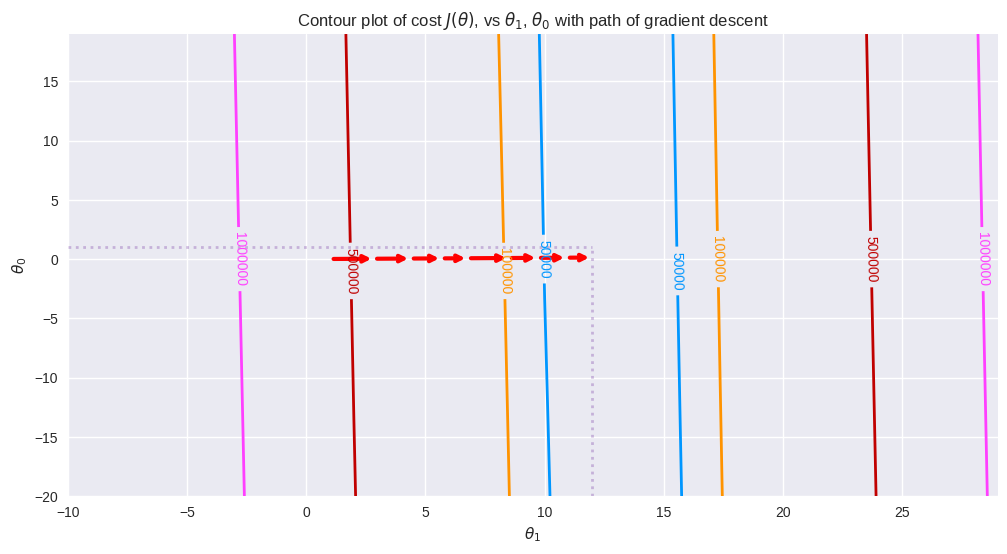

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plt_contour_wgrad(X_train, Y_train, p_hist, ax)

Above, the contour plot shows the $cost(\theta_1, \theta_0)$ over a range of $\theta_1$ and $\theta_0$. Cost levels are represented by the colored lines. However, it does not seem to be a bowl shaped function.
Overlayed, using red arrows, we plot the path of gradient descent. Here are two things to note:
1. The path makes steady (monotonic) progress toward its goal.
2. initial steps are much larger than the steps near the goal.

**Zooming out**, we can see the level rings, showing that it is a bowl-shaped function, although the slope is much steeper in one of the directions, and quite flat in the other. Note again the distance between steps shrinks as the gradient approaches zero.

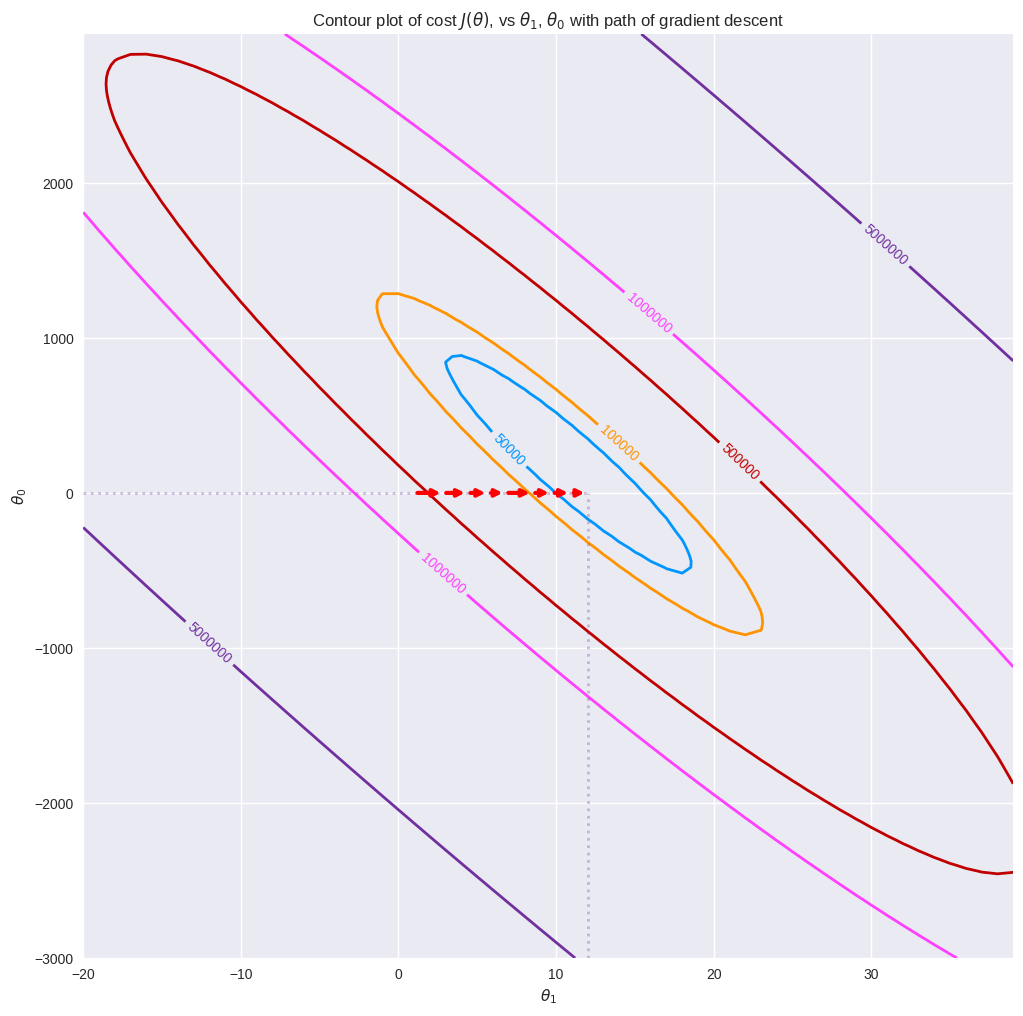

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
plt_contour_wgrad(X_train,Y_train, p_hist, ax, theta1_range=[-20, 40, 1], theta0_range=[-3000, 3000, 40],
                  contours=[50000,100000,500000,1000000,5000000],resolution=1)


Next, we will plot below the value of the cost w.r.t. the iterations perform by gradient descent.




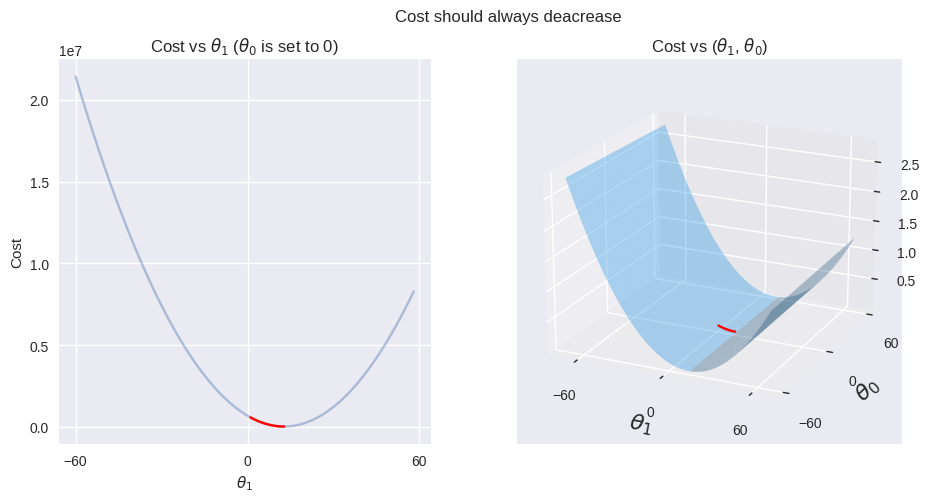

In [ ]:
plt_cost_vs_theta1(p_hist, J_hist, X_train,Y_train)

Now copy in the cell below all the code to run the optimization of $\theta_1$ and $\theta_0$ using the function `gradient_descent`, but this time, we will change the starting values, so that we initialise `theta1_init` and `theta0_init`
to 80 and 2000, respectively. Start running 100,000 iterations of the gradient descent algorithm. And set the learning rate $\alpha$ to 0.0001. **Does it still converge?**

```
# initialise starting values of the parameters
theta1_init = 80
theta0_init = 2000
# increase the iterations to 100,000
iterations = 100000
# decrease a bit the learning rate to see if it still converges
alpha = 1.0e-4
```


In [ ]:
compute_cost(X_train,Y_train,80,2000)

31441712.931972787

In [ ]:
compute_gradient(X_train,Y_train,80,2000)

(710103.2142857143, 7582.863945578231)

In [ ]:
#_____________TO DO_____________
#gradient_descent(X_train, Y_train, theta1_init, theta0_init, alpha,iterations, compute_cost, compute_gradient, vis)
gradient_descent(X_train,Y_train,80,2000,1e-4,100000,compute_cost, compute_gradient, 0)

Iteration    0: Cost 1.39e+06 dj_dtheta1:  7.101e+05, dj_dtheta0:  7.583e+03 theta1:  8.990e+00, theta0: 1.99924e+03
Iteration 10000: Cost 1.88e+05 dj_dtheta1: -2.255e+00, dj_dtheta0:  2.184e+02 theta1: -5.443e+00, theta0: 1.76480e+03
Iteration 20000: Cost 1.46e+05 dj_dtheta1: -1.964e+00, dj_dtheta0:  1.902e+02 theta1: -3.337e+00, theta0: 1.56083e+03
Iteration 30000: Cost 1.14e+05 dj_dtheta1: -1.710e+00, dj_dtheta0:  1.656e+02 theta1: -1.503e+00, theta0: 1.38323e+03
Iteration 40000: Cost 9.05e+04 dj_dtheta1: -1.489e+00, dj_dtheta0:  1.442e+02 theta1:  9.349e-02, theta0: 1.22861e+03
Iteration 50000: Cost 7.24e+04 dj_dtheta1: -1.296e+00, dj_dtheta0:  1.255e+02 theta1:  1.484e+00, theta0: 1.09397e+03
Iteration 60000: Cost 5.86e+04 dj_dtheta1: -1.128e+00, dj_dtheta0:  1.093e+02 theta1:  2.694e+00, theta0: 9.76750e+02
Iteration 70000: Cost 4.82e+04 dj_dtheta1: -9.826e-01, dj_dtheta0:  9.516e+01 theta1:  3.748e+00, theta0: 8.74687e+02
Iteration 80000: Cost 4.03e+04 dj_dtheta1: -8.555e-01, dj

(6.159761838150791,
 641.0864820478041,
 [1390387.4228330473,
  284947.74288575334,
  244278.24381106102,
  242776.16042529937,
  242714.8448704627,
  242706.52791764124,
  242700.16067852362,
  242693.8653272068,
  242687.5727881358,
  242681.28052037116,
  242674.98843044025,
  242668.69651490008,
  242662.4047736195,
  242656.11320658884,
  242649.821813803,
  242643.53059525756,
  242637.239550947,
  242630.94868086744,
  242624.6579850134,
  242618.36746337992,
  242612.0771159627,
  242605.78694275644,
  242599.49694375717,
  242593.20711895864,
  242586.91746835705,
  242580.62799194778,
  242574.3386897252,
  242568.04956168483,
  242561.7606078219,
  242555.47182813153,
  242549.1832226092,
  242542.89479124977,
  242536.60653404825,
  242530.3184509999,
  242524.03054210052,
  242517.7428073443,
  242511.45524672733,
  242505.16786024408,
  242498.8806478902,
  242492.5936096606,
  242486.30674555045,
  242480.02005555521,
  242473.73353966983,
  242467.4471978896,
  242461.1

### Cost versus iterations of gradient descent
Plot again the  cost versus iterations, but now the iterations are much higher: the change in cost is so rapid initially that it is useful to plot the initial descent on a different scale than the final descent.

In the plots below, note the scale of cost on the axes and the iteration step.

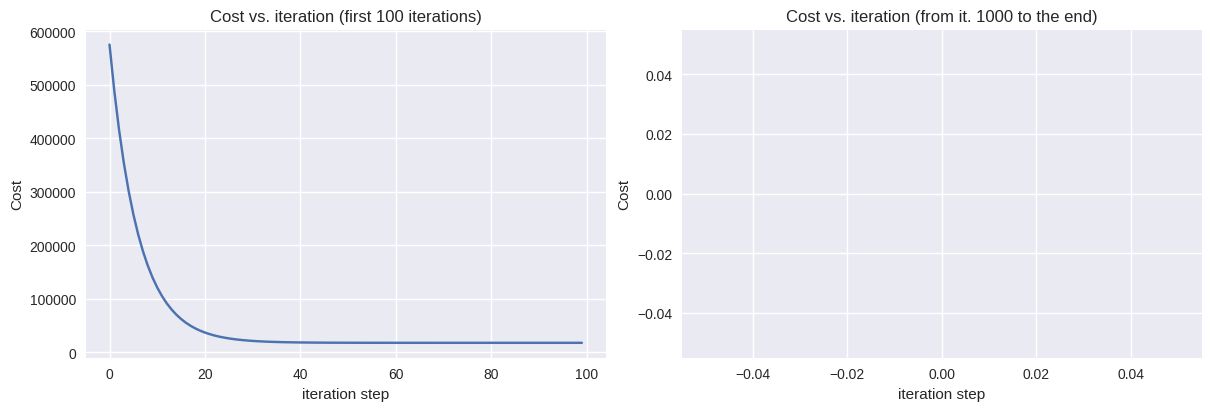

100

In [ ]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration (first 100 iterations)");  ax2.set_title("Cost vs. iteration (from it. 1000 to the end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()
np.size(J_hist)

Looking at the plots above, does gradient descent still converge?

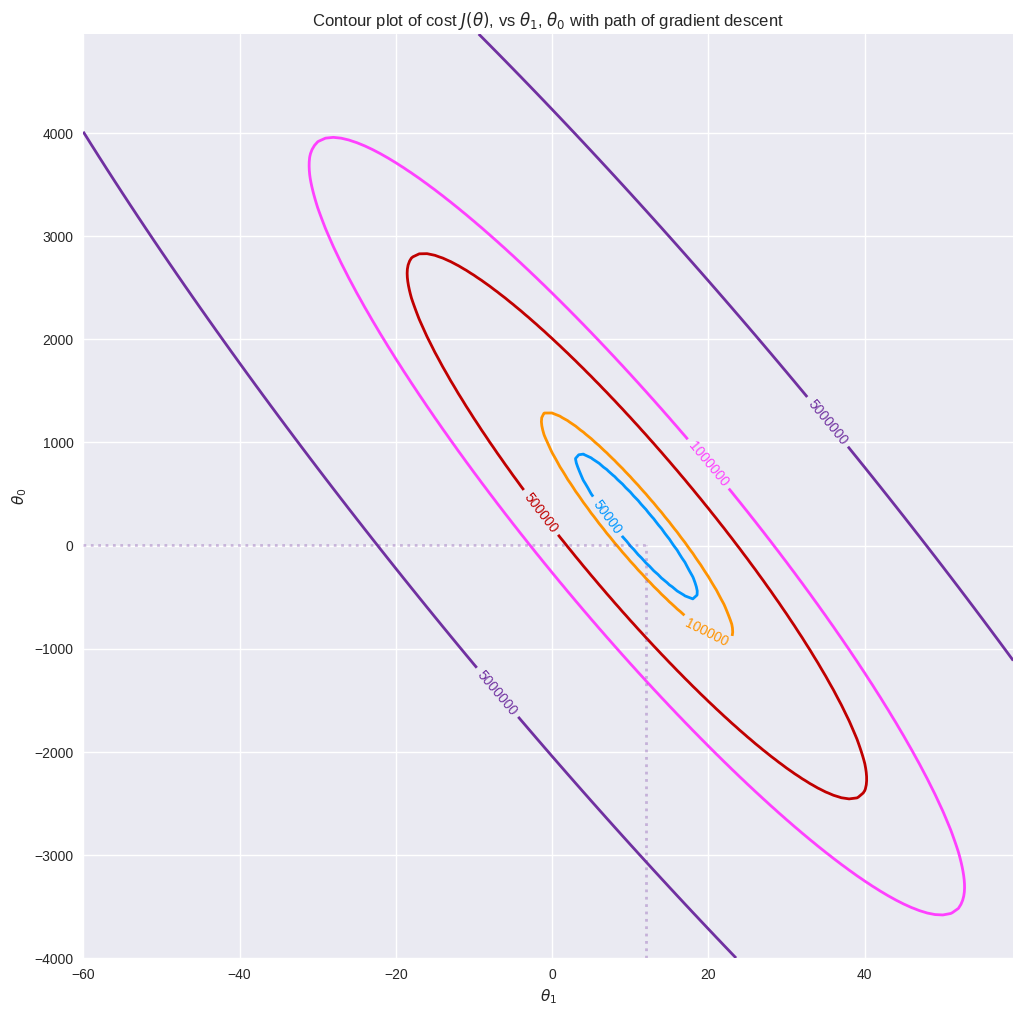

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
plt_contour_wgrad(X_train, Y_train, p_hist, ax, theta1_range=[-60, 60, 1], theta0_range=[-4000, 5000, 40],
                  contours=[50000,100000,500000,1000000,5000000],resolution=100)


Note that the steps taken by the gradient descent algorithm are bigger or smaller depending on the gradient (that is, the slope) at which the function is evaluated.


In the lecture, there was a discussion related to the proper value of the learning rate, $\alpha$ in equation (3). The larger $\alpha$ is, the faster gradient descent will converge to a solution. But, if it is too large, gradient descent will diverge. Above you have an example of a solution which converges nicely.

Let's try increasing the value of  $\alpha$ and see what happens:
- copy the optimization code in the cell below
- initialise again $\theta_1$ and $\theta_0$ to 0
- set a larger learning rate (set it to `3.0e-4`).

What happens to the cost?


In [ ]:
# initialize parameters
theta1_init = 0#_____________TO DO_____________
theta0_init = 0#_____________TO DO_____________

# some gradient descent settings
iterations = 100000 #_____________TO DO_____________
alpha =  3e-4    #_____________TO DO_____________
vis = 0
# run gradient descent
theta_1_final, theta_0_final, J_hist, p_hist = gradient_descent(X_train, Y_train, theta1_init, theta0_init, alpha,
                                                    iterations, compute_cost, compute_gradient, vis)
print(f"(theta1, theta0) found by gradient descent: ({theta_1_final:5.4f},{theta_0_final:5.4f})")

Iteration    0: Cost 1.36e+06 dj_dtheta1: -1.033e+05, dj_dtheta0: -1.092e+03 theta1:  3.098e+01, theta0: 3.27671e-01


<ipython-input-36-95d2f71299df>:9: RuntimeWarning: overflow encountered in double_scalars
  cost = cost + (h_theta - y[i])**2
<ipython-input-37-202a102c3943>:23: RuntimeWarning: overflow encountered in double_scalars
  dj_dtheta1 += dj_dtheta1_i
<ipython-input-39-049a92759a5d>:35: RuntimeWarning: invalid value encountered in double_scalars
  theta1 = theta1 - alpha * dj_dtheta1


Iteration 10000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 20000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 30000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 40000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 50000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 60000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 70000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 80000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
Iteration 90000: Cost nan dj_dtheta1:  nan, dj_dtheta0:  nan theta1:  nan, theta0: nan
(theta1, theta0) found by gradient descent: (  nan,  nan)


Above, what you see in the cost is a clear sign that the *learning rate is too large* and the solution is diverging.
Let's visualize this with a plot.

/content/aux_utils.py:272: RuntimeWarning: overflow encountered in double_scalars
  edist = np.sqrt((base[0] - point[0])**2 + (base[1] - point[1])**2)


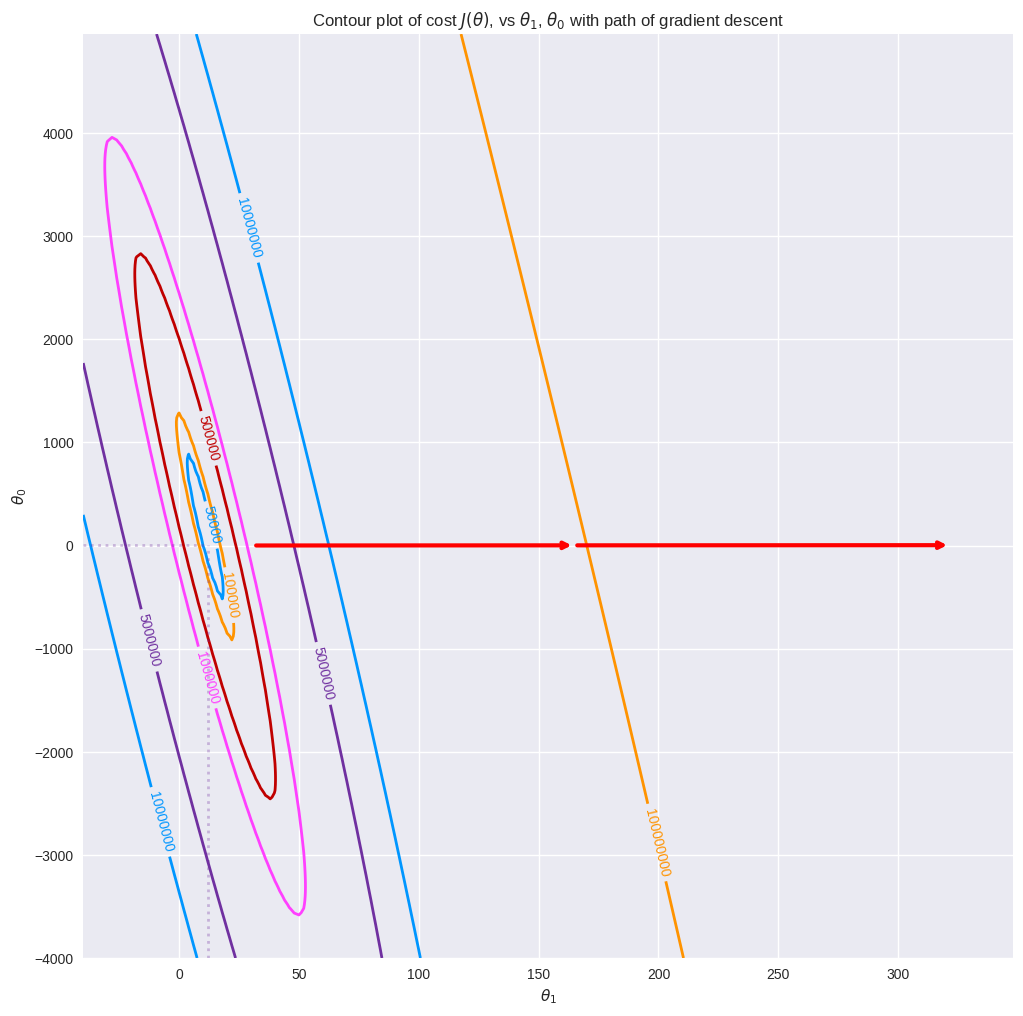

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
plt_contour_wgrad(X_train, Y_train, p_hist, ax, theta1_range=[-40, 350, 2], theta0_range=[-4000, 5000, 40],
                  contours=[50000,100000,500000,1000000,5000000, 10000000, 100000000],resolution=100)

### How to check if gradient descent is working
In this lab, we have been able to visualize the cost function, because it only depends on two parameters, $\theta_1$ and $\theta_0$. However, normally, you can't visualize a cost function in higher dimensions, so the way to find out if the learning rate is too big is to look at the evolution of the cost w.r.t. the number of iterations.

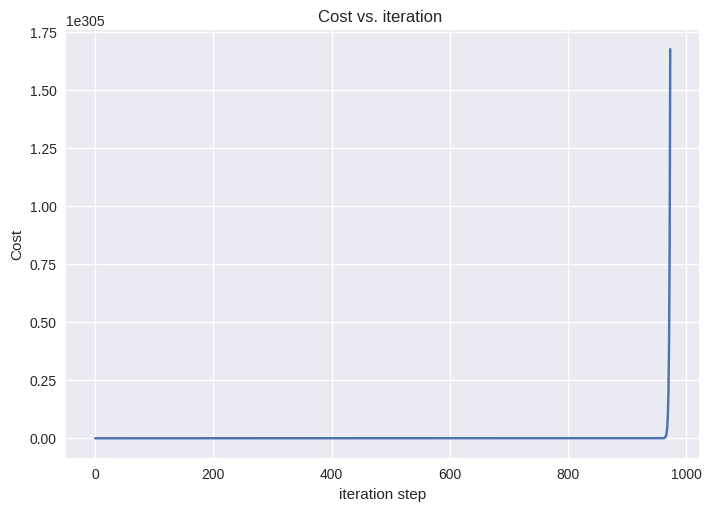

100000

In [ ]:
# plot cost versus iteration
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(7,5))
ax.plot(J_hist)
ax.set_title("Cost vs. iteration ")
ax.set_ylabel('Cost')
ax.set_xlabel('iteration step')
plt.show()
np.size(J_hist)

Again, due to the different scales, it is difficult to interpret what happens on the first iterations. Let's break down this plot into two plots, one for the first iterations, and a second one for the last ones. Note the different scales of both plots.

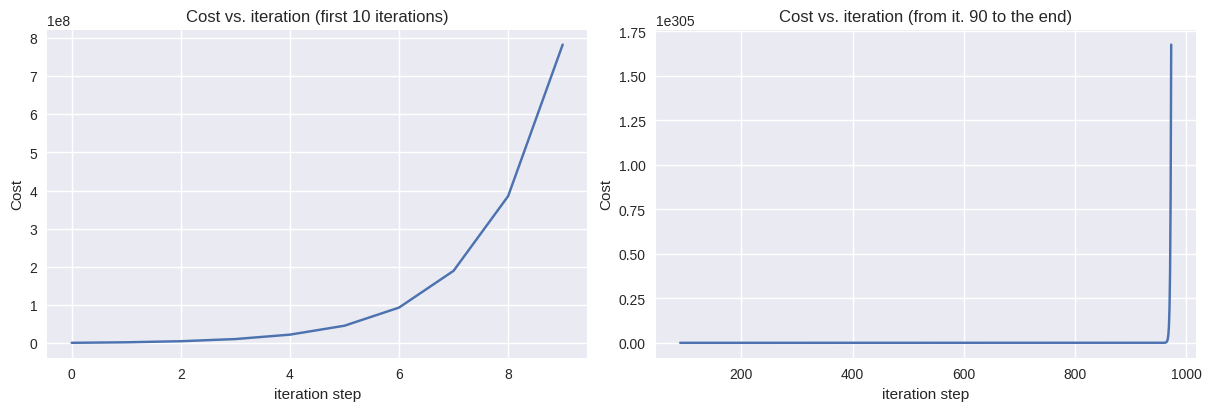

100000

In [ ]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
cut1 = 10 ; cut2 = 90
ax1.plot(J_hist[:cut1])
ax2.plot(cut2 + np.arange(len(J_hist[cut2:])), J_hist[cut2:])
ax1.set_title(f"Cost vs. iteration (first {cut1} iterations)");  ax2.set_title(f"Cost vs. iteration (from it. {cut2} to the end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()
np.size(J_hist)


## Congratulations!
In this lab you:
- delved into the details of gradient descent for a single variable.
- developed a routine to compute the gradient
- visualized what the gradient is
- completed a gradient descent routine
- utilized gradient descent to find parameters
- examined the impact of sizing the learning rate

Submit this notebook by the lab deadline, with the cells executed and including your **answers** in the text fields in $\color{red}{\text{red}}$ color.